# Cumulative distance

Calculating the cumulative distance traveled by a set of particle trajectories in km. The distances traveled during every timestep of the trajecotry are added together.

* Author(s): Laura Gomez Navarro
* Created on: 20/05/22
* Last updated on:

In [1]:
import time

print(time.ctime(time.time()))

Sun Sep 21 19:06:38 2025


### 0.  Imports and package versions

In [2]:
%matplotlib inline
from datetime import timedelta, datetime
from glob import glob
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.dates as mdates
import xarray as xr

from matplotlib import colors 
import matplotlib.gridspec as gridspec

import cartopy
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

from collections import namedtuple
from shapely import geometry

import scipy 
from scipy import stats, optimize, interpolate

import sys
import inspect

### 1. Loading the data

In [3]:
filedir = '../../Simulations/'

In [4]:
ds = xr.open_dataset(filedir + 'toy_data_01.nc')

In [5]:
ds

<xarray.Dataset> Size: 627kB
Dimensions:     (traj: 144, obs: 121)
Dimensions without coordinates: traj, obs
Data variables:
    trajectory  (traj, obs) float64 139kB ...
    time        (traj, obs) datetime64[ns] 139kB ...
    lat         (traj, obs) float32 70kB ...
    lon         (traj, obs) float32 70kB ...
    z           (traj, obs) float32 70kB ...
    U           (traj, obs) float32 70kB ...
    V           (traj, obs) float32 70kB ...
Attributes:
    feature_type:           trajectory
    Conventions:            CF-1.6/CF-1.7
    ncei_template_version:  NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_version:        2.3.1.dev20+g92f2fb90
    parcels_mesh:           spherical

### 2. Calculating the distance

### 2.1. Loading the functions

In [6]:
sys.path.insert(0, "Functions/")

In [7]:
import numpy as np
import math

def dist_km(lona, lonb, lata, latb):
    """
    Function to calculate the distance between 2 points in km
    Haversine formula used, which assumes the Earth is a sphere.
    source: https://stackoverflow.com/questions/19412462/getting-distance-between-two-points-based-on-latitude-longitude
    """

    R = 6373.0     # approximate radius of earth in km

    lat1 = math.radians(lata)
    lon1 = math.radians(lona)
    lat2 = math.radians(latb)
    lon2 = math.radians(lonb)

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = math.sin(dlat / 2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon / 2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))

    distance = R * c

    return distance

def cumulative_distance_01(ds_n, nsavedir=None):

    # Creating the output data array:
    dist_01 = ds_n.lon.copy() * np.nan

    # Calculating the distance traveled by every particle at every timestep:
    for tt in range(0, len(ds_n.traj)):
        lon_t = ds_n.lon[tt, :].dropna(dim='obs')
        lat_t = ds_n.lat[tt, :].dropna(dim='obs')

        for oo in range(1, len(lat_t)): # calculate as distance at x0 = distance at x-x0
            dist_01[tt, oo-1] = dist_km(lon_t[oo-1], lon_t[oo], lat_t[oo-1], lat_t[oo])

    # Calculating the cumulative distance traveled for all particle trajectories at every timestep:
    cum_dist_01 = dist_01.cumsum(dim='obs')

    if nsavedir:
        cum_dist_01.to_netcdf(nsavedir + "cum_dist_01.nc")

    return cum_dist_01


### 2.2. Applying the cumulative distance function:

In [8]:
cum_dist_01 = cumulative_distance_01(ds)


In [9]:
cum_dist_01

<xarray.DataArray 'lon' (traj: 144, obs: 121)> Size: 70kB
array([[  16.403774,   30.603819,   43.689835, ..., 2255.6865  ,
        2266.414   , 2266.414   ],
       [  19.366917,   38.18978 ,   56.715897, ..., 1715.984   ,
        1729.1825  , 1729.1825  ],
       [  24.746086,   56.121193,   92.32692 , ..., 1781.5177  ,
        1783.5271  , 1783.5271  ],
       ...,
       [  40.99772 ,   86.607864,  134.14404 , ..., 1845.9026  ,
        1854.615   , 1854.615   ],
       [  30.890318,   71.60733 ,  118.270065, ..., 2146.9658  ,
        2167.6208  , 2167.6208  ],
       [  14.378509,   33.60996 ,   58.250862, ..., 2269.991   ,
        2274.8174  , 2274.8174  ]], shape=(144, 121), dtype=float32)
Dimensions without coordinates: traj, obs

**--> gives the cumulative distance traveled for every particle at every timesep.**

### 3. Plotting the outputs

### 3.1. Plotting cumulative distance evolution in time for the first 10 particle trajectories

Text(0.5, 0, 'Date')

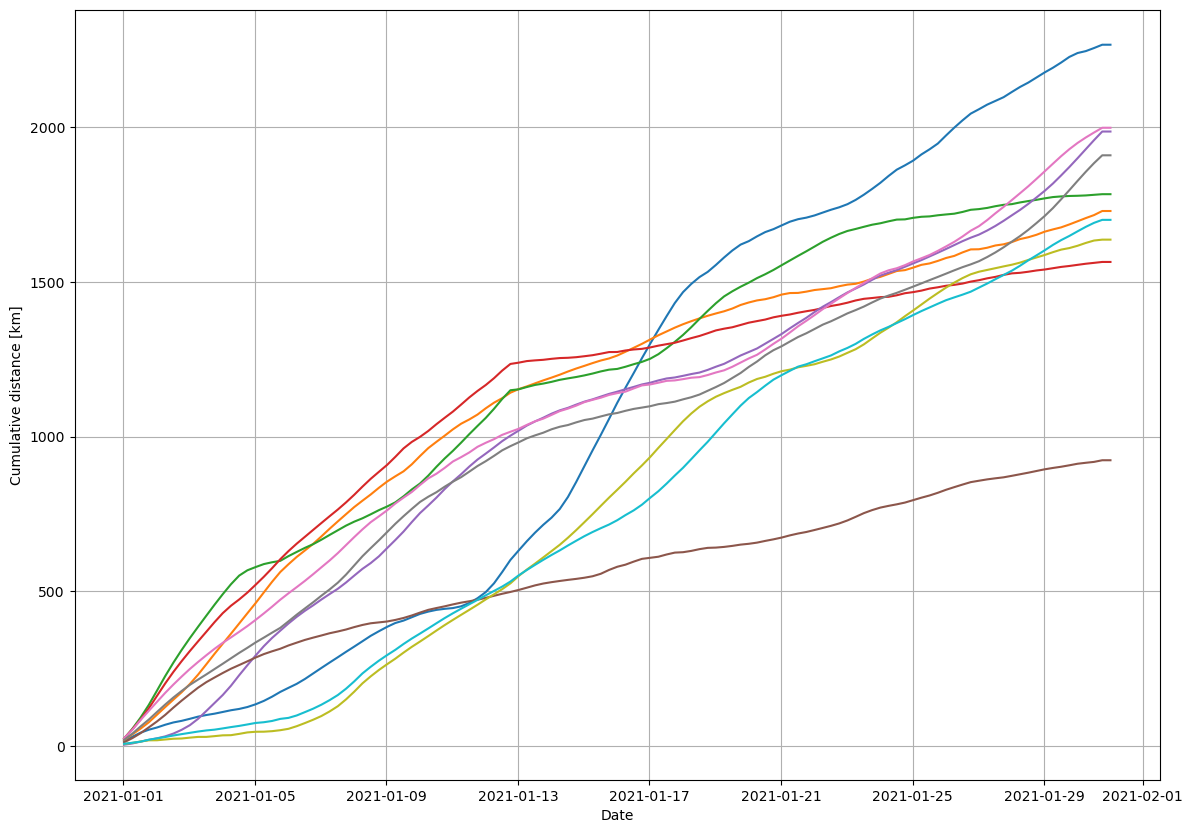

In [10]:
plt.figure(figsize=(14,10))
plt.plot(ds.time[0,:], cum_dist_01[0:10,:].T)
plt.grid()
plt.ylabel('Cumulative distance [km]')
plt.xlabel('Date')

### 3.2. Boxplot of the final cumulative distance of all the particles:

In [11]:
cum_dist_final = ((cum_dist_01.max(dim='obs')).where(cum_dist_01.max(dim='obs') != 0., drop=True)).data


In [12]:
cum_dist_final.shape

(144,)

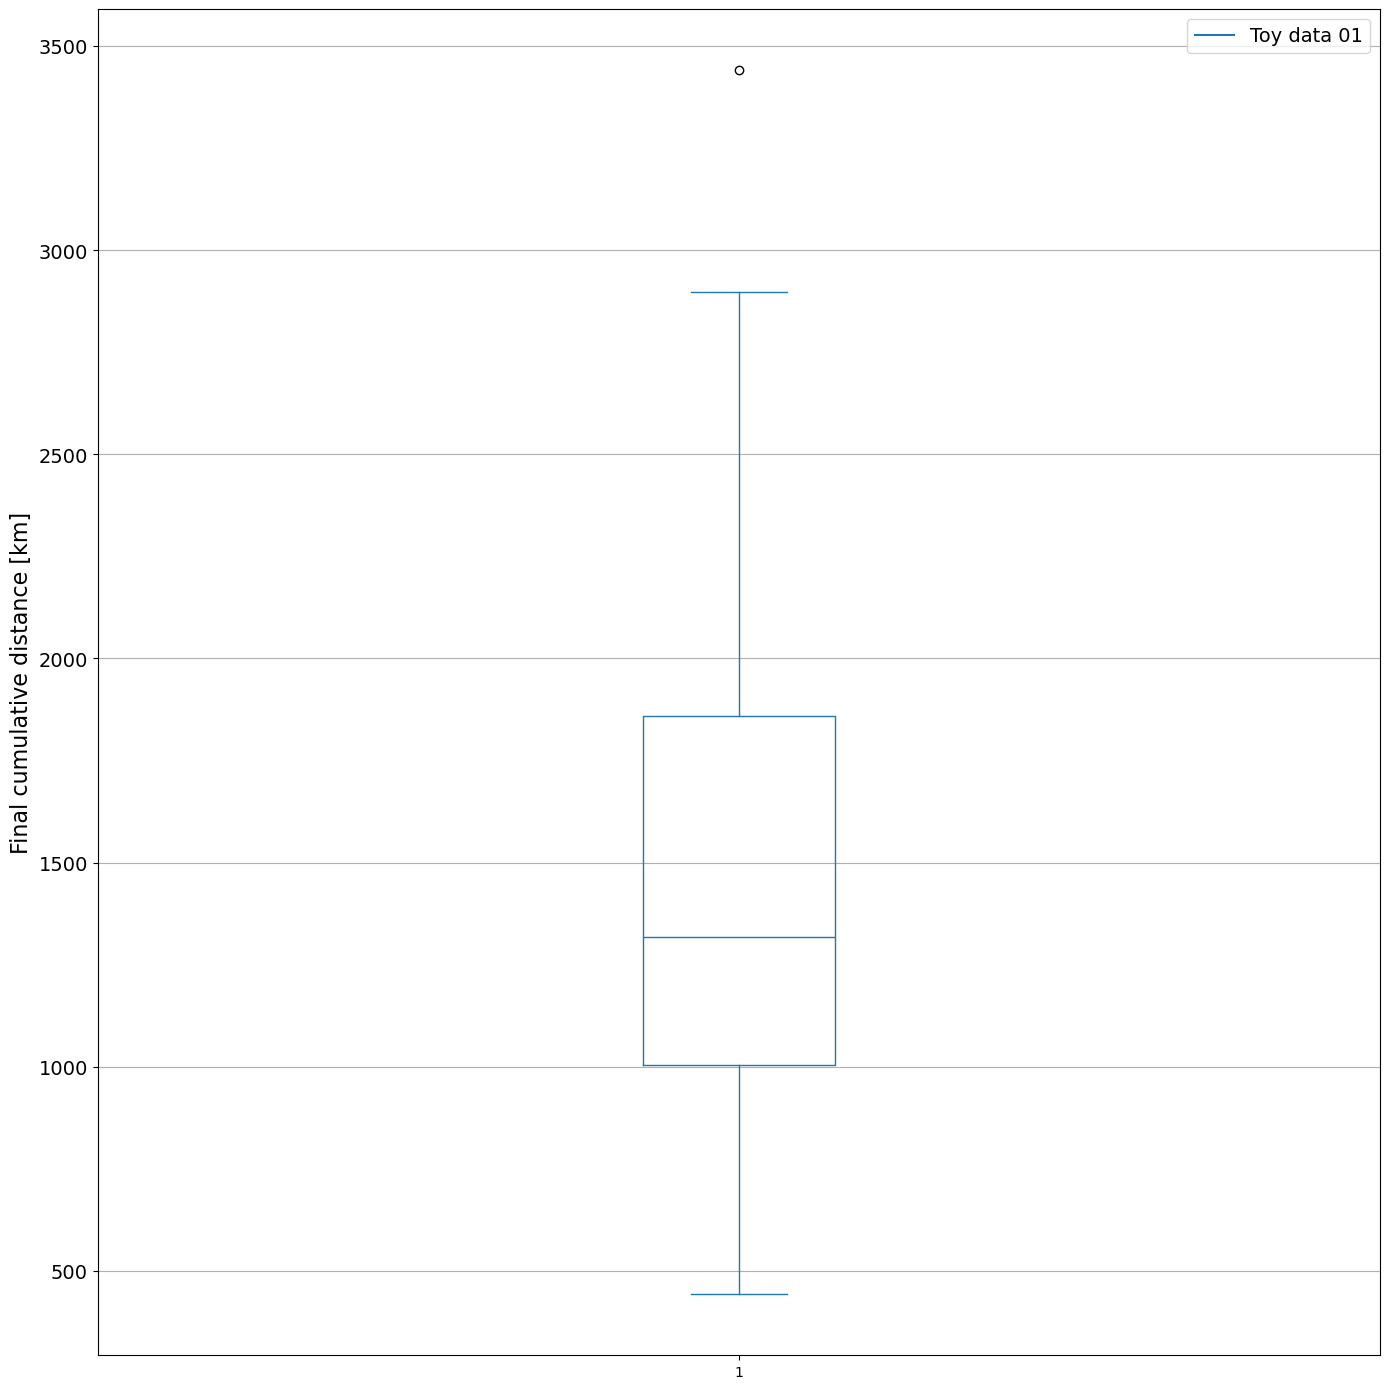

In [13]:
def set_box_color(bp, color):
    plt.setp(bp['boxes'], color=color)
    plt.setp(bp['whiskers'], color=color)
    plt.setp(bp['caps'], color=color)
    plt.setp(bp['medians'], color=color)
#     plt.setp(bp['facecolor'], color=color)

plt.figure(figsize=(14,14))
ax1 = plt.subplot(111)

bpl = ax1.boxplot(cum_dist_final) #, positions=np.array(range(len(dist_cum_a)))*2.0-0.4, sym='', widths=0.6)
set_box_color(bpl, 'C0') # colors are from http://colorbrewer2.org/

# draw temporary red and blue lines and use them to create a legend
plt.plot([], c='C0', label='Toy data 01')
# plt.plot([], c='C3', label='Tidal forcing')
plt.legend(fontsize=14)
# ax.legend(fontsize=14)

# plt.xticks(range(0, len(ticks) * 2, 2), ticks, fontsize=14)
plt.yticks(fontsize=14)
# plt.xlim(-2, len(ticks)*2)
# plt.ylim(0, 850)
# ax1.set_xticklabels(labels, rotation=45, horizontalalignment='right')
# plt.grid()
ax1.yaxis.grid()
ax1.set_ylabel('Final cumulative distance [km]', size=16)

plt.tight_layout()
# plt.savefig('figs/cumsum_km_and_total_dist_km_BOXPLOT_01.jpg', dpi=300)
plt.show()